In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

%matplotlib inline

## Load the various required model objects from the preprocessor data

In [2]:
import pickle
import gzip

with gzip.open('processed_inputs_190531.p.gz', 'rb') as f:
    preprocessor_data = pickle.load(f)

Using TensorFlow backend.


In [3]:
preprocessor_data.keys()

dict_keys(['preprocessor', 'train', 'valid', 'train_smiles', 'valid_smiles', 'test_smiles', 'train_df', 'valid_df'])

The prediction target here is the 'Test Smiles', which are just smiles strings of the molecules in the test set.

In [4]:
preprocessor_data['train_df'].dropna().shape

(923234, 9)

In [5]:
preprocessor_data['train_df'].dropna().drop_duplicates(['molecule', 'fragment1', 'fragment2']).shape

(276717, 9)

In [6]:
len(preprocessor_data['train_smiles'])

40577

In [7]:
len(preprocessor_data['valid_smiles'])

1000

In [8]:
preprocessor_data['test_smiles'][:5]

array(['CCc1c[nH]c(C#N)c1C', 'Cc1cccc(=O)n1N',
       'C=C(C)[C@H](O)[C@H](O)/C=C/C', 'CC1(C)COCCN1N', 'CCCOC(=O)C(C)=O'],
      dtype=object)

here we use the preprocessor class to turn the SMILES strings into something the model can injest

In [9]:
preprocessor = preprocessor_data['preprocessor']
inputs_new = preprocessor.predict(preprocessor_data['test_smiles'])

100%|██████████| 1000/1000 [00:00<00:00, 2429.88it/s]


This code block makes sure that none of the test set compounds have atom / bond classes that are unknown by the preprocessor (i.e., not in the training set)

In [10]:
def check_input(iinput):
    if 1 in iinput['bond']:
        return False
    if 1 in iinput['atom']:
        return False
    else:
        return True    

is_valid = np.array([check_input(i) for i in inputs_new])
print(preprocessor_data['test_smiles'][~is_valid])

inputs_new = [i for i in inputs_new if check_input(i)]
test_smiles = preprocessor_data['test_smiles'][is_valid]

[]


In [11]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)

In [12]:
# Plot the training / validation loss for the model
log = pd.read_csv('layer_runs2/n_message_6/log.csv')

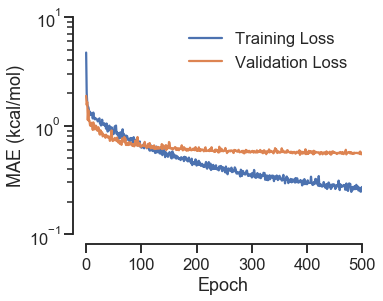

In [13]:
plt.figure(figsize=(5,4))
lines = plt.semilogy(log.set_index('epoch'))
plt.ylim([.1, 10])
plt.legend(lines, ['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylabel('MAE (kcal/mol)')
plt.xlabel('Epoch')
plt.xlim([-5, 500])
plt.xticks([0, 100, 200, 300, 400, 500])
sns.despine(offset=10, trim=True)

Load the model and predict the train, validation, and test set inputs

In [14]:
from keras.models import load_model
from nfp import custom_layers, GraphModel
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    model = load_model('layer_runs2/n_message_6/best_model.hdf5', custom_objects=custom_layers)
    
    
layer_df = pd.DataFrame(((l.name, l) for l in model.layers), columns=['name', 'layer'])
layer_df = layer_df.set_index('name').layer
layer_df.head()
    
embedding_model = GraphModel(model.inputs, [model.layers[-3].input])
# model.summary()

In [15]:
from preprocessor_utils import ConcatGraphSequence

train_pred = model.predict_generator(
    ConcatGraphSequence(preprocessor_data['train'][0], batch_size=128, shuffle=False), verbose=1)

valid_pred = model.predict_generator(
    ConcatGraphSequence(preprocessor_data['valid'][0], batch_size=128, shuffle=False), verbose=1)

new_pred = model.predict_generator(
    ConcatGraphSequence(inputs_new, batch_size=128, shuffle=False), verbose=1)

train_embeddings = embedding_model.predict_generator(
    ConcatGraphSequence(preprocessor_data['train'][0], batch_size=128, shuffle=False), verbose=1)

valid_embeddings = embedding_model.predict_generator(
    ConcatGraphSequence(preprocessor_data['valid'][0], batch_size=128, shuffle=False), verbose=1)

test_embeddings = embedding_model.predict_generator(
    ConcatGraphSequence(inputs_new, batch_size=128, shuffle=False), verbose=1)

8/8 [==============================] - 0s 6ms/step


This block transforms the ambiguous model outputs into a Pandas dataframe with the bond_index and molecule attributes; which allows us to compare the predicted BDEs against ones we've previously calculated.

In [16]:
def inputs_to_dataframe(smiles, inputs):
    molecule = np.repeat(np.array(smiles), np.stack([iinput['n_bond'] for iinput in inputs]))
    bond_index = np.concatenate([iinput['bond_indices'] for iinput in inputs])
    input_df = pd.DataFrame(np.vstack([molecule, bond_index]).T, columns=['molecule', 'bond_index'])
    input_df['bond_index'] = input_df.bond_index.astype('int64')
    
    return input_df

y_new_df = inputs_to_dataframe(test_smiles, inputs_new)
y_new_df['bde_pred'] = new_pred

train_df = preprocessor_data['train_df']
valid_df = preprocessor_data['valid_df']

train_df['bde_pred'] = train_pred
valid_df['bde_pred'] = valid_pred

In [17]:
y_new_df.shape

(39812, 3)

In [18]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=(
    ('PCA', PCA(n_components=10)),
    ('NearestNeighbors', NearestNeighbors(n_neighbors=5))
))

pipe.fit(train_embeddings[preprocessor_data['train_df'].bde.notnull()])

def pipe_kneighbors(pipe, X):
    Xt = pipe.steps[0][-1].transform(X)
    return pipe.steps[-1][-1].kneighbors(Xt)

(array([ 269.,  755.,  827., 1475., 2246., 4523., 8292., 7309., 6229.,
        7929.]),
 array([-6.93183669, -5.84234609, -4.75285548, -3.66336488, -2.57387428,
        -1.48438368, -0.39489307,  0.69459753,  1.78408813,  2.87357874,
         3.96306934]),
 <a list of 10 Patch objects>)

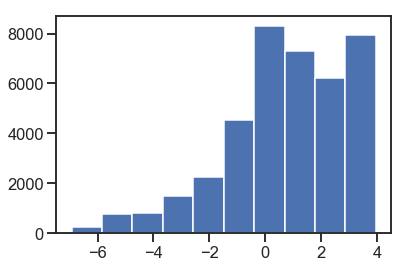

In [19]:
valid_distances, valid_indices = pipe_kneighbors(
    pipe, valid_embeddings)

valid_df['distance'] = np.log(valid_distances).mean(1)
plt.hist(valid_df.distance)

(array([ 298.,  886.,  853., 1451., 2452., 4812., 8428., 6901., 6496.,
        7235.]),
 array([-6.62182991, -5.56112398, -4.50041806, -3.43971213, -2.3790062 ,
        -1.31830027, -0.25759435,  0.80311158,  1.86381751,  2.92452343,
         3.98522936]),
 <a list of 10 Patch objects>)

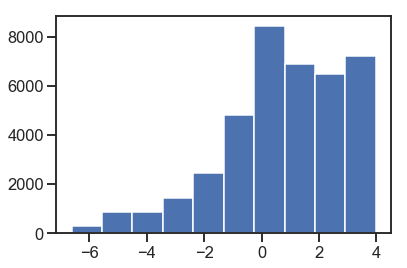

In [20]:
test_distances, test_indices = pipe_kneighbors(
    pipe, test_embeddings)

y_new_df['distance'] = np.log(test_distances).mean(1)
plt.hist(y_new_df.distance)

Here we load calculated BDE values for all molecules, and merge the BDE database on the predicted DataFrame on the molecule and bond_index fields (these should be deterministic)

In [21]:
# Each bond in my model is predicted twice -- here we group by molecule
# and bond_index and take the mean of both predictions, getting one prediction
# for each BDE.
test_predictions = y_new_df.groupby(['molecule', 'bond_index']).mean().reset_index()
test_predictions.head()

bde = pd.read_csv('rdf_data_190531.csv.gz', index_col=0)
test_predictions = test_predictions.merge(
    bde, how='left', left_on=['bond_index', 'molecule'],
    right_on=['bond_index', 'molecule'])

test_predictions.head()

,molecule,bond_index,bde_pred,distance,fragment1,fragment2,bde,bond_type,delta_stereo
0,C#C/C(C)=C/CNCC,0,98.621292,3.521571,NaN,NaN,NaN,NaN,NaN
1,C#C/C(C)=C/CNCC,1,132.957977,0.697301,[C]#C,C[C]=CCNCC,132.918956,C-C,0.0
2,C#C/C(C)=C/CNCC,2,90.212418,1.012540,C#C/[C]=C/CNCC,[CH3],90.545156,C-C,0.0
3,C#C/C(C)=C/CNCC,3,95.206955,3.162290,NaN,NaN,NaN,NaN,NaN
4,C#C/C(C)=C/CNCC,4,92.262199,2.539400,[CH2]NCC,[CH]=C(C)C#C,92.585188,C-C,0.0


In [22]:
test_dedupe = test_predictions.dropna().drop_duplicates(subset=['molecule', 'fragment1', 'fragment2'])

In [23]:
((test_dedupe.bde - test_dedupe.bde_pred).abs() < 2.25).sum() / len(test_dedupe)

0.9525043177892919

Here we load calculated BDE values for all molecules, and merge the BDE database on the predicted DataFrame on the molecule and bond_index fields (these should be deterministic)

In [24]:
# Each bond in my model is predicted twice -- here we group by molecule
# and bond_index and take the mean of both predictions, getting one prediction
# for each BDE.
test_predictions = y_new_df.groupby(['molecule', 'bond_index']).mean().reset_index()
test_predictions.head()

bde = pd.read_csv('rdf_data_190531.csv.gz', index_col=0)
test_predictions = test_predictions.merge(
    bde, how='left', left_on=['bond_index', 'molecule'],
    right_on=['bond_index', 'molecule'])

test_predictions.head()

,molecule,bond_index,bde_pred,distance,fragment1,fragment2,bde,bond_type,delta_stereo
0,C#C/C(C)=C/CNCC,0,98.621292,3.521571,NaN,NaN,NaN,NaN,NaN
1,C#C/C(C)=C/CNCC,1,132.957977,0.697301,[C]#C,C[C]=CCNCC,132.918956,C-C,0.0
2,C#C/C(C)=C/CNCC,2,90.212418,1.012540,C#C/[C]=C/CNCC,[CH3],90.545156,C-C,0.0
3,C#C/C(C)=C/CNCC,3,95.206955,3.162290,NaN,NaN,NaN,NaN,NaN
4,C#C/C(C)=C/CNCC,4,92.262199,2.539400,[CH2]NCC,[CH]=C(C)C#C,92.585188,C-C,0.0


In [25]:
test_predictions.dropna(subset=['bde']).drop_duplicates(['molecule', 'fragment1', 'fragment2']).to_csv('test_bdes.csv.gz', compression='gzip')

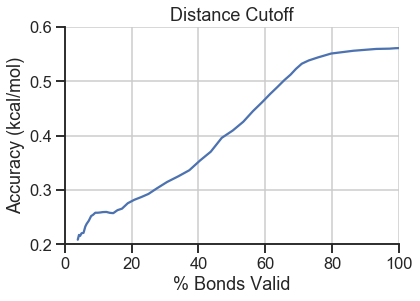

In [26]:
threshs = np.linspace(-4, 4)

acc = []
valid_percent = []

for thres in threshs:
    acc += [(valid_df[valid_df.distance < thres].bde -
             valid_df[valid_df.distance < thres].bde_pred).abs().mean()]
    valid_percent += [(valid_df.distance < thres).sum() / len(valid_df) * 100]


plt.plot(valid_percent, acc)
plt.ylabel('Accuracy (kcal/mol)')  
plt.xlabel('% Bonds Valid')
plt.xlim([0, 100])
plt.ylim([.2, .6001])

plt.grid()
plt.title('Distance Cutoff')
sns.despine(trim=True)

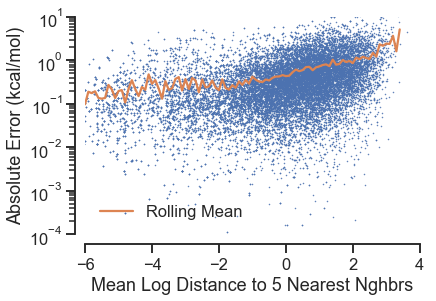

In [27]:
plt.semilogy(valid_df['distance'],
             (valid_df['bde'] - valid_df['bde_pred']).abs(),
             '.', ms=1)
plt.semilogy((valid_df['bde'] - valid_df['bde_pred']).abs().groupby(
    valid_df.distance.round(1)).mean(), label='Rolling Mean')
plt.ylim([1E-4, 1E1])
plt.xlim([-6, 4])

plt.ylabel('Absolute Error (kcal/mol)')
plt.xlabel('Mean Log Distance to 5 Nearest Nghbrs')

plt.legend(loc='lower left')

sns.despine(trim=True, offset=10)

Plot the parity of held-out data predictions

In [28]:
to_follow = [3, 2, 8, 19, 4, 16, 43, 7]
chosen_bonds = train_df[
    train_df.bde.notnull() &
    train_df.preprocessor_class.isin(to_follow)].sample(
    5000, random_state=1)

### Get 1st, 3rd, and 6th bond embeddings

In [29]:
layer_df = pd.DataFrame(((l.name, l) for l in model.layers), columns=['name', 'layer'])
layer_df = layer_df.set_index('name').layer
layer_df.head()

name
bond              <keras.engine.input_layer.InputLayer object at...
atom              <keras.engine.input_layer.InputLayer object at...
squeeze_1         <nfp.layers.layers.Squeeze object at 0x7f3a7af...
atom_embedding    <keras.layers.embeddings.Embedding object at 0...
bond_embedding    <keras.layers.embeddings.Embedding object at 0...
Name: layer, dtype: object

In [30]:
GraphModel

nfp.models.models.GraphModel

In [31]:
layer_df[layer_df.index.str.startswith('add_')]

name
add_1     <keras.layers.merge.Add object at 0x7f3a7afaa2e8>
add_2     <keras.layers.merge.Add object at 0x7f3a7afaa780>
add_3     <keras.layers.merge.Add object at 0x7f3a7afaad30>
add_4     <keras.layers.merge.Add object at 0x7f3a7af9f208>
add_5     <keras.layers.merge.Add object at 0x7f3a7af9f7b8>
add_6     <keras.layers.merge.Add object at 0x7f3a7af9fc50>
add_7     <keras.layers.merge.Add object at 0x7f3a823104e0>
add_8     <keras.layers.merge.Add object at 0x7f3a823106d8>
add_9     <keras.layers.merge.Add object at 0x7f3a82310c88>
add_10    <keras.layers.merge.Add object at 0x7f3a8231a160>
add_11    <keras.layers.merge.Add object at 0x7f3a8231a710>
add_13    <keras.layers.merge.Add object at 0x7f3a8231a908>
Name: layer, dtype: object

In [32]:
embedding_model_1 = GraphModel(model.inputs, [layer_df['add_1'].output])
embedding_model_3 = GraphModel(model.inputs, [layer_df['add_7'].output])
embedding_model_6 = GraphModel(model.inputs, [layer_df['add_11'].output])

In [33]:
train_embeddings_1 = embedding_model_1.predict_generator(
    ConcatGraphSequence(preprocessor_data['train'][0], batch_size=128, shuffle=False),
    verbose=1)[chosen_bonds.index]
train_embeddings_3 = embedding_model_3.predict_generator(
    ConcatGraphSequence(preprocessor_data['train'][0], batch_size=128, shuffle=False),
    verbose=1)[chosen_bonds.index]
train_embeddings_6 = embedding_model_6.predict_generator(
    ConcatGraphSequence(preprocessor_data['train'][0], batch_size=128, shuffle=False),
    verbose=1)[chosen_bonds.index]

318/318 [==============================] - 2s 7ms/step


In [34]:
from sklearn.manifold import TSNE

pipe = Pipeline(steps=(
    ('PCA', PCA(n_components=10)),
    ('TSNE', TSNE(n_components=2))
))

xt_1 = pipe.fit_transform(train_embeddings_1)
xt_3 = pipe.fit_transform(train_embeddings_3)
xt_6 = pipe.fit_transform(train_embeddings_6)

In [35]:
N = len(to_follow)

In [36]:
xt_1.shape

(5000, 2)

In [37]:
chosen_bonds.head()

,bond_index,preprocessor_class,molecule,mol_index,fragment1,fragment2,bde,bond_type,delta_stereo,bde_pred
270972,18,3,CCCNCCNC,6846,[H],CCCNC[CH]NC,88.728518,C-H,0.0,88.815346
708607,1,2,C#CCOc1ccncc1,17901,[C]#C,[CH2]Oc1ccncc1,118.911073,C-C,0.0,119.155266
1419014,0,4,COC1=C(C)CC=CC1,35873,CC1=C([O])CC=CC1,[CH3],55.246520,C-O,0.0,53.565842
689621,18,3,Cc1cc2ncc[nH]c-2c1,17416,[H],Cc1[c]c2[nH]ccnc-2c1,116.849078,C-H,0.0,117.072372
1365817,2,2,C=CCCC(=O)OCC,34527,[CH2]C(=O)OCC,[CH2]C=C,71.574932,C-C,0.0,71.595612


In [38]:
import rdkit.Chem

def featurize_atom(atom):
    symbol = atom.GetSymbol()
    if symbol == 'C':
        aro = atom.GetIsAromatic()
        ring = atom.IsInRing()
        
        if aro:
            return 'C(aro)'
        elif ring:
            return 'C(ring)'
        else:
            return 'C'
    else:
        return symbol
    
def featurize_bond(row):
    
    mol = rdkit.Chem.MolFromSmiles(row.molecule)
    molH = rdkit.Chem.AddHs(mol)
    bond = molH.GetBondWithIdx(row.bond_index)
    atom1 = bond.GetBeginAtom()
    atom2 = bond.GetEndAtom()
    
    symbol1 = featurize_atom(atom1)
    symbol2 = featurize_atom(atom2)
    
    order = ['C(aro)', 'C(ring)', 'C', 'N', 'O', 'H']
    symbols = [item for item in order if item in (symbol1, symbol2)]
    if len(symbols) == 1:
        symbols = [symbols[0], symbols[0]]

    return '-'.join(symbols)

In [39]:
chosen_bonds['bond_class_annotated'] = chosen_bonds.apply(featurize_bond, 1)

In [40]:
class_count = chosen_bonds.groupby('bond_class_annotated').bond_type.count()
class_count = class_count[class_count > 50].sort_values()

In [41]:
class_count

bond_class_annotated
O-H           106
C(aro)-C      135
C(ring)-C     144
C-N           163
C(aro)-H      182
C-O           206
N-H           255
C(ring)-H     612
C-C          1003
C-H          2098
Name: bond_type, dtype: int64

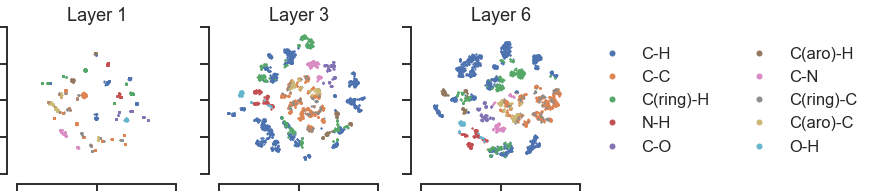

In [42]:
fig, axmatrix = plt.subplots(ncols=3, figsize=(9,3), sharex=True, sharey=True)
#for ax in axmatrix:
#    ax.set_aspect('equal')
    
for bond_type in class_count.index[::-1]:
    
    df = chosen_bonds.reset_index()[(chosen_bonds.bond_class_annotated == bond_type).values]
    axmatrix[0].plot(xt_1[df.index, 0], xt_1[df.index, 1], '.', ms=2, zorder=-1)
    axmatrix[1].plot(xt_3[df.index, 0], xt_3[df.index, 1], '.', ms=2, zorder=-1)
    axmatrix[2].plot(xt_6[df.index, 0], xt_6[df.index, 1], '.', ms=2, label=bond_type, zorder=-1)
        
axmatrix[0].set_title('Layer 1')
axmatrix[1].set_title('Layer 3')
axmatrix[2].set_title('Layer 6')

axmatrix[0].set_xlim([-100, 100])
axmatrix[0].set_ylim([-100, 100])

plt.tight_layout()
sns.despine(offset=10)

axmatrix[0].set_rasterization_zorder(0)
axmatrix[1].set_rasterization_zorder(0)
axmatrix[2].set_rasterization_zorder(0)


for ax in axmatrix:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

leg = axmatrix[2].legend(loc='center left', bbox_to_anchor=(1., .5), markerscale=5, ncol=2)
fig.savefig('embeddings.svg', bbox_extra_artists=(leg,), dpi=600)

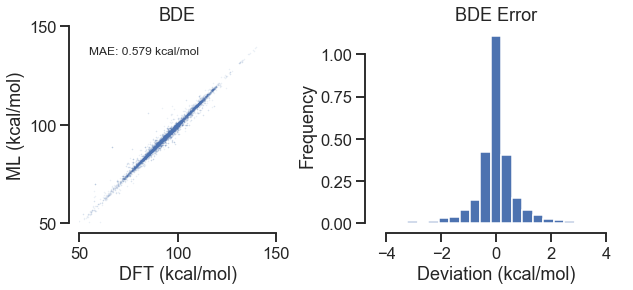

In [43]:
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(121, aspect='equal')
ax1.plot(test_predictions.bde, test_predictions.bde_pred, '.', ms=1, alpha=.1, rasterized=True)
# ax1.plot([50, 150], [50, 150], '--', color='.3', lw=1, zorder=0)

#ax1.plot(y_valid_df.bde, y_valid_df.bde_pred, '.', ms=1, alpha=0.1)

ax2 = fig.add_subplot(122)
ax2.hist((test_predictions.bde - test_predictions.bde_pred).dropna(), bins=21, range=(-4, 4), density=True)

# hpd = pm.hpd((test_predictions.bde - test_predictions.bde_pred).dropna())
# ax2.axvline(hpd[0], color='.8', zorder=0, ls='--')
# ax2.axvline(hpd[1], color='.8', zorder=0, ls='--')

ax2.set_xticks([-4, -2, 0, 2, 4])
# ax2.set_xlim([-4, 4])


ax1.set_xlim([50, 150])
ax1.set_ylim([50, 150])

ax1.set_xticks([50, 100, 150])
ax1.set_yticks([50, 100, 150])

mae = (test_predictions.bde - test_predictions.bde_pred).abs().mean()
ax1.text(0.05, .9, "MAE: {0:.3f} kcal/mol".format(mae), ha='left', va='top',
         transform=ax1.transAxes, fontsize='large')

ax1.set_title('BDE')
ax1.set_ylabel('ML (kcal/mol)')
ax1.set_xlabel('DFT (kcal/mol)')

ax2.set_title('BDE Error')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Deviation (kcal/mol)')

plt.tight_layout()
sns.despine(trim=True, offset=10)
plt.savefig('parity.svg', dpi=500)

In [44]:
train_df = preprocessor_data['train_df']
valid_df = preprocessor_data['valid_df']

train_df['bde_pred'] = train_pred
valid_df['bde_pred'] = valid_pred

all_predictions = pd.concat([train_df, valid_df, test_predictions], sort=False)
all_predictions = all_predictions.drop_duplicates(subset=['molecule', 'bond_index'])

In [45]:
all_predictions['abs_err'] = (all_predictions.bde - all_predictions.bde_pred).abs()
all_predictions.sort_values('abs_err', ascending=False).head()

,bond_index,preprocessor_class,molecule,mol_index,fragment1,fragment2,bde,bond_type,delta_stereo,bde_pred,distance,abs_err
19823,11,NaN,c1cccnccncc1,NaN,[H],[c]1cccnccncc1,89.003994,C-H,0.0,12.602245,2.399342,76.401749
19822,10,NaN,c1cccnccncc1,NaN,[H],[c]1cccnccncc1,89.003994,C-H,0.0,12.602245,2.399342,76.401749
1369512,9,3.0,C1=CC=C/N=N\CC=C1,34622.0,[H],[C]1=CC=C/N=N\CC=C1,22.913491,C-H,0.0,89.991974,NaN,67.078483
628765,8,5.0,C/C=C(C)/C=C\C(=O)OC,15881.0,C/C=C(C)/C=C\C([O])=O,[CH3],50.426623,C-O,0.0,93.207466,NaN,42.780843
959289,15,3.0,c1ccncccncc1,24256.0,[H],[c]1ccncccccn1,41.518505,C-H,0.0,12.633364,NaN,28.885142


### Code for drawing BDEs

In [46]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def draw_bde(smiles, bond_index, figsize=(300, 300)):
    
    mol = Chem.MolFromSmiles(smiles)
    bond_index = int(bond_index)

    if bond_index >= mol.GetNumBonds():

        molH = Chem.AddHs(mol)
        bond = molH.GetBondWithIdx(bond_index)

        start_atom = mol.GetAtomWithIdx(bond.GetBeginAtomIdx())
        mol = Chem.AddHs(mol, onlyOnAtoms=[start_atom.GetIdx()])
        bond_index = mol.GetNumBonds() - 1

    bond = mol.GetBondWithIdx(bond_index)
    if not mol.GetNumConformers():
        rdDepictor.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(*figsize)
    drawer.SetFontSize(.6)
    drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=[bond_index,])

    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()

    svg = svg.replace('svg:', '').replace(':svg', '')
    
    return SVG(svg)

In [47]:
sorted_preditions = all_predictions.sort_values('abs_err', ascending=False)
sorted_preditions = sorted_preditions.drop_duplicates(subset='molecule', keep='first')
sorted_preditions.head(50)

,bond_index,preprocessor_class,molecule,mol_index,fragment1,fragment2,bde,bond_type,delta_stereo,bde_pred,distance,abs_err
19823,11,NaN,c1cccnccncc1,NaN,[H],[c]1cccnccncc1,89.003994,C-H,0.0,12.602245,2.399342,76.401749
1369512,9,3.0,C1=CC=C/N=N\CC=C1,34622.0,[H],[C]1=CC=C/N=N\CC=C1,22.913491,C-H,0.0,89.991974,NaN,67.078483
628765,8,5.0,C/C=C(C)/C=C\C(=O)OC,15881.0,C/C=C(C)/C=C\C([O])=O,[CH3],50.426623,C-O,0.0,93.207466,NaN,42.780843
959289,15,3.0,c1ccncccncc1,24256.0,[H],[c]1ccncccccn1,41.518505,C-H,0.0,12.633364,NaN,28.885142
675875,12,3.0,Cc1cccc(=N)n1N,17072.0,[H],Cc1[c]ccc(=N)n1N,140.521228,C-H,0.0,115.003647,NaN,25.517581
480913,14,8.0,c1cc2[nH]cc3c2nc1C3,12140.0,[H],C1=C2Cc3ccc(c2n3)[N]1,60.009313,H-N,0.0,84.983322,NaN,24.974009
889624,18,16.0,COc1c(N)cccc1O,22492.0,[H],COc1c(N)cccc1[O],110.272157,H-O,0.0,87.867752,NaN,22.404404
979,7,NaN,C1=CCCCC=1,NaN,[H],C1=C[CH]CCC=1,66.882419,C-H,0.0,88.961945,0.050192,22.079525
934623,10,16.0,C=C(O)CC(=C)N(C)C,23631.0,[H],C=C([O])CC(=C)N(C)C,106.763754,H-O,0.0,84.828285,NaN,21.935469
1476119,17,3.0,c1ccccncccc1,37321.0,[H],[c]1ccccccncc1,34.235009,C-H,0.0,12.698486,NaN,21.536522


bde         93.65
bde_pred    93.29
Name: 25702, dtype: float64


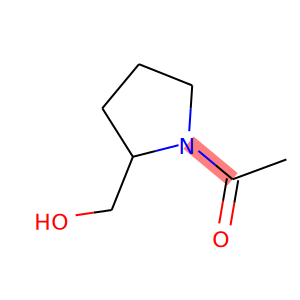

In [48]:
index = 25702
print(all_predictions.loc[index, ['bde', 'bde_pred']].astype(float).round(2))
draw_bde(all_predictions.loc[index, 'molecule'],
         all_predictions.loc[index, 'bond_index'])

In [49]:
cdf = pd.read_csv('cdf_data_190531.csv.gz').set_index('smiles')
import os
cdf['logbase'] = cdf.logfile.apply(os.path.basename)

In [50]:
sorted_preditions_subset = sorted_preditions[['molecule', 'fragment1', 'fragment2', 'bond_type', 'bde', 'bde_pred', 'abs_err']]

In [51]:
predictions_with_logfiles = sorted_preditions_subset.merge(
    cdf[['logbase']].rename(columns={'logbase': 'logfile_mol'}),
    left_on='molecule', right_index=True, how='left').merge(
    cdf[['logbase']].rename(columns={'logbase': 'logfile_frag1'}),
    left_on='fragment1', right_index=True, how='left').merge(
    cdf[['logbase']].rename(columns={'logbase': 'logfile_frag2'}),
    left_on='fragment2', right_index=True, how='left')

In [52]:
predictions_with_logfiles['set'] = None

In [53]:
predictions_with_logfiles.loc[predictions_with_logfiles.molecule.isin(train_df.molecule.unique()), 'set'] = 'Train'
predictions_with_logfiles.loc[predictions_with_logfiles.molecule.isin(valid_df.molecule.unique()), 'set'] = 'Valid'
predictions_with_logfiles.loc[predictions_with_logfiles.molecule.isin(test_smiles), 'set'] = 'Test'

In [54]:
predictions_with_logfiles.sort_values('bde').groupby('bond_type').head(3).to_csv('20190903_weakest_bonds.csv')

In [55]:
predictions_with_logfiles_subset = predictions_with_logfiles.head(50)

In [56]:
predictions_with_logfiles_subset

,molecule,fragment1,fragment2,bond_type,bde,bde_pred,abs_err,logfile_mol,logfile_frag1,logfile_frag2,set
19823,c1cccnccncc1,[H],[c]1cccnccncc1,C-H,89.003994,12.602245,76.401749,436028_bb98b4.log.gz,12_0.log.gz,11020_0.log.gz,Test
1369512,C1=CC=C/N=N\CC=C1,[H],[C]1=CC=C/N=N\CC=C1,C-H,22.913491,89.991974,67.078483,518295_fbf2d3.log.gz,12_0.log.gz,521782_72475e.log.gz,Train
628765,C/C=C(C)/C=C\C(=O)OC,C/C=C(C)/C=C\C([O])=O,[CH3],C-O,50.426623,93.207466,42.780843,450857_ae3cb0.log.gz,511355_064c0c.log.gz,20_0.log.gz,Train
959289,c1ccncccncc1,[H],[c]1ccncccccn1,C-H,41.518505,12.633364,28.885142,516706_4c4d7b.log.gz,12_0.log.gz,520253_f46240.log.gz,Train
675875,Cc1cccc(=N)n1N,[H],Cc1[c]ccc(=N)n1N,C-H,140.521228,115.003647,25.517581,517322_c8dea2.log.gz,12_0.log.gz,520843_8b871b.log.gz,Train
480913,c1cc2[nH]cc3c2nc1C3,[H],C1=C2Cc3ccc(c2n3)[N]1,H-N,60.009313,84.983322,24.974009,218537_c16069.log.gz,12_0.log.gz,515042_5a2b08.log.gz,Train
889624,COc1c(N)cccc1O,[H],COc1c(N)cccc1[O],H-O,110.272157,87.867752,22.404404,519564_6a4147.log.gz,12_0.log.gz,522996_2115cf.log.gz,Train
979,C1=CCCCC=1,[H],C1=C[CH]CCC=1,C-H,66.882419,88.961945,22.079525,510654_d91fd8.log.gz,12_0.log.gz,513477_f4e6e1.log.gz,Test
934623,C=C(O)CC(=C)N(C)C,[H],C=C([O])CC(=C)N(C)C,H-O,106.763754,84.828285,21.935469,519361_0d00e7.log.gz,12_0.log.gz,522801_ea0a0d.log.gz,Train
1476119,c1ccccncccc1,[H],[c]1ccccccncc1,C-H,34.235009,12.698486,21.536522,516705_1ce506.log.gz,12_0.log.gz,520249_33efd2.log.gz,Train


In [57]:
predictions_with_logfiles.shape

(42577, 11)

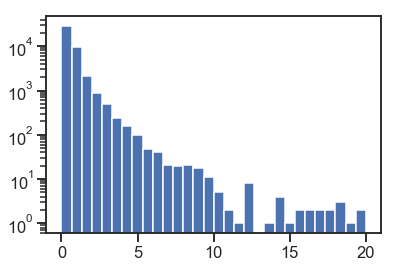

In [58]:
plt.hist(sorted_preditions.abs_err, bins=30, range=(0, 20))
plt.yscale('log')

In [59]:
predictions_with_logfiles_subset.to_csv('20190903_outlier_predictions.csv')

In [60]:
from shutil import copyfile

In [61]:
for log in set(predictions_with_logfiles_subset[['logfile_mol', 'logfile_frag1', 'logfile_frag2']].values.flatten()):
    copyfile(os.path.join('/projects/cooptimasoot/psj_bde/log/', log), os.path.join('20190819_outlier_logs/', log))

In [62]:
cdf[cdf.id == 511355]

,id,enthalpy,mol,run,run_at,logfile,type,logbase
smiles,,,,,,,,
C/C=C(C)/C=C\C([O])=O,511355,-422.398721,511355\n RDKit 3D\n\n 18 17 0 0...,7,2019-05-02 15:10:00.177961,/projects/cooptimasoot/psj_bde/log/511355_064c...,fragment,511355_064c0c.log.gz
